In [2]:
import pandas as pd
import numpy as pd 
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim

import numpy as np 
from torch.autograd import Variable
from scipy.spatial import distance_matrix
import torch.nn as nn

### Toy dataset:

Text(0.5, 1.0, 'Make moons dataset')

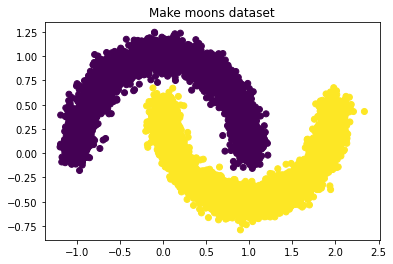

In [3]:
np.random.seed(3)
X,y = make_moons(n_samples=10_000,noise=0.08)
plt.scatter(X[:,0],X[:,1],c=y)
plt.title("Make moons dataset")

In [4]:
# Split 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.25, random_state=1)


# Scale 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


# Convert to torch tensors
X_train=torch.from_numpy(X_train.astype(np.float32))
X_test=torch.from_numpy(X_test.astype(np.float32))
y_train=torch.from_numpy(y_train.astype(np.float32))
y_test=torch.from_numpy(y_test.astype(np.float32))
X_val=torch.from_numpy(X_val.astype(np.float32))
y_val=torch.from_numpy(y_val.astype(np.float32))

# Reshape to fit a model
y_train=y_train.view(y_train.shape[0],1)
y_test=y_test.view(y_test.shape[0],1)
y_val=y_val.view(y_val.shape[0],1)

### MLP model :

In [5]:
# MLP in pytorch 
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input = torch.nn.Linear(2, 5)
        self.output = torch.nn.Linear(5, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.ReLU = torch.nn.ReLU()
    def forward(self, x):
        x_input = self.input(x)
        x_output = self.output(self.ReLU(x_input))
        out = self.sigmoid(x_output)
        return out   


model = MLP()

'''
# Define the loss
criterion=torch.nn.BCELoss(reduction="mean")
# Define the Optimizer 
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

train_loss = [] 
valid_loss = []

model.train()
number_of_epochs=10_000
for epoch in range(number_of_epochs):

    # Train 

    y_prediction=model(X_train)
    loss=criterion(y_prediction,y_train)
    train_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%10 == 0:
        print('epoch:', epoch+1,',loss=',loss.item())

    # Valid
    with torch.no_grad():
        y_prediction_val=model(X_val)    
        loss_valid=criterion(y_prediction_val,y_val)    
        valid_loss.append(loss_valid.item())   

model.eval()
with torch.no_grad():
    y_pred=model(X_test)
    y_pred_class=y_pred.round()
    accuracy=(y_pred_class.eq(y_test).sum())/float(y_test.shape[0])
    print("Accuracy on test is {}:".format(accuracy.item()))
    
plt.plot(range(number_of_epochs),train_loss,label="train_loss")
plt.plot(range(number_of_epochs),valid_loss,label="valid_loss")
plt.legend()
plt.title("Loss")

torch.save(model.state_dict(),"mlp_toy_model")

'''
model.load_state_dict(torch.load("mlp_toy_model"))

<All keys matched successfully>

In [6]:
with torch.no_grad():
    # Predictions on train 
    y_pred_train_proba = model(X_train)
    y_pred_train_class = y_pred_train_proba.round().numpy().flatten()
    # Predictions on test 
    y_pred_test_proba = model(X_test)
    y_pred_test_class = y_pred_test_proba.round().numpy().flatten()

Decision frontier : 

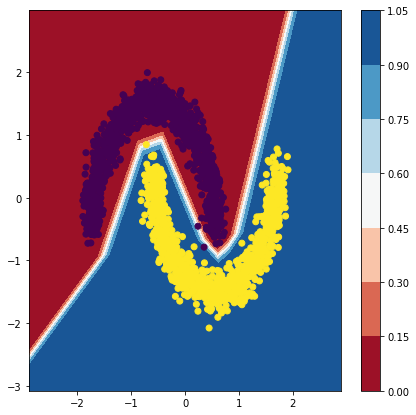

In [7]:
X_plot = X_test.numpy()

plot_step = 0.02
x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()) 
#Z = (Z > 0.5).int()

Z = Z.reshape(xx.shape).detach().numpy()


plt.figure(figsize=(7,7))
c = plt.contourf(xx, yy, Z, cmap="RdBu")
plt.colorbar(c)
plt.scatter(X_plot[:,0],X_plot[:,1],c=y_test.numpy())

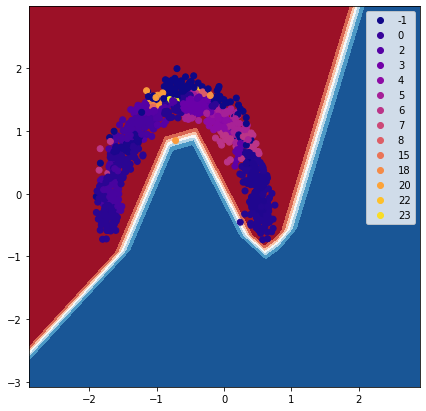

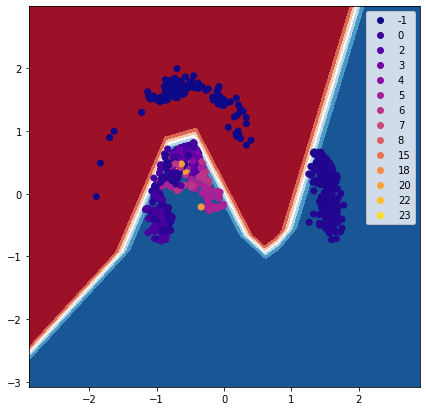

In [78]:
X_plot = X_test.numpy()
Lambda = np.linspace(1e-2,1e-4,10)
lambda_param = Lambda[8]
plot_step = 0.02
x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()) 
#Z = (Z > 0.5).int()

Z = Z.reshape(xx.shape).detach().numpy()


plt.figure(figsize=(7,7))
c = plt.contourf(xx, yy, Z, cmap="RdBu")
cb = plt.colorbar(c)
cb.remove()

pred_class=0
cluster_label = np.loadtxt("results/cluster_label_class={}_lambda={}.txt".format(pred_class,lambda_param))
perturbs =  np.loadtxt("results/perturbs_class={}_lambda={}.txt".format(pred_class,lambda_param))
X_cluster = X_test[y_pred_test_class==pred_class]

all_perturbs = np.vstack([perturbs[e] for e in cluster_label.astype(int)])
X_new = X_cluster + all_perturbs

# index of points that are alone in a cluster
index = np.where((X_new == X_cluster).all(axis=1))[0]
# group points thare alone in a cluster in the same cluster 
cluster_label_new = cluster_label.copy()
for i in index : 
    cluster_label_new[i] = -1 
scatter = plt.scatter(X_cluster[:,0],X_cluster[:,1],c=cluster_label_new,cmap="plasma")
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(cluster_label_new).astype(int).astype(str)))
plt.figure(figsize=(7,7))
c = plt.contourf(xx, yy, Z, cmap="RdBu")
cb = plt.colorbar(c)
cb.remove()
scatter = plt.scatter(X_new[:,0],X_new[:,1],c=cluster_label_new,cmap="plasma")
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(cluster_label_new).astype(int).astype(str)))

In [69]:
perturbs

array([[ 1.13167095,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.78272796, -0.20946524],
       [ 1.03565311,  0.00187063],
       [ 1.02280509,  0.        ],
       [ 0.0223141 , -0.85761899],
       [ 0.81480104,  0.        ],
       [-0.34858161, -0.79129273],
       [ 0.257285  , -0.86227167],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.66821206, -0.46450481],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.19175531, -0.80632466],
       [ 0.        ,  0.        ],
       [ 0.55494374, -0.74179369],
       [ 0.        ,  0.        ],
       [-0.18166961, -0.92091835],
       [-0.65716553, -0.22423688],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.15625684, -0.80370456],
       [ 0.        ,

In [58]:
cluster_label[[13,14,15,16]]

array([4., 4., 4., 4.])

In [59]:
perturbs[[13,14,15,16]]

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.66821206, -0.46450481],
       [ 0.        ,  0.        ]])

In [76]:
all_perturbs

array([[ 0.66821206, -0.46450481],
       [ 1.02280509,  0.        ],
       [-0.46734136, -0.53049135],
       ...,
       [ 0.81480104,  0.        ],
       [ 1.03565311,  0.00187063],
       [ 1.03565311,  0.00187063]])